In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np, os, pandas as pd
from glob import glob
import os
import scipy
import numpy as np
import plotly.graph_objects as go

In [65]:
plt.style.use('plotting_style_sheet.txt')

In [79]:
files = sorted(glob("./../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-980/fullSimulationOutputs/*"))

In [80]:
for file in files:
    data = np.loadtxt(file)
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    xaxis = np.arange(1, 9, 1)*4.8+2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    plt.plot(xaxis,data)
    name = os.path.basename(file).rstrip('.txt')
    plt.title(name)
    fig.savefig('./../figures/nn2DicomComp/NathanOpt001/' + name + '_Run001_plot.png')
    plt.close(fig)

In [81]:
files2 = sorted(glob("./../neural_nets/JuliaOutputs/OptimizedRuns/Run000R2-980/fullSimulationOutputs/*"))

In [82]:
for file in files2:
    data = np.loadtxt(file)
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    xaxis = np.arange(1, 9, 1)*4.8+2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    plt.plot(xaxis,data)
    name = os.path.basename(file).rstrip('.txt')
    plt.title(name)
    fig.savefig('./../figures/nn2DicomComp/NathanOpt000/' + name + '_Run000_plot.png')
    plt.close(fig)

In [83]:
files3 = sorted(glob("./../neural_nets/JuliaOutputs/RubinRuns/Run000R2-944/fullOhioOutputs/*"))

In [84]:
for file in files3:
    data = np.loadtxt(file)
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    xaxis = np.arange(1, 9, 1)*4.8+2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    plt.plot(xaxis,data)
    name = os.path.basename(file).rstrip('.txt')
    plt.title(name)
    fig.savefig('./../figures/nn2DicomComp/RubinPlots/' + name + '_Run000_plot.png')
    plt.close(fig)

In [ ]:
files4 = sorted(glob("./../neural_nets/JuliaOutputs/tegan_runs/"))

/home/jupyter-owen/.conda/envs/dosimeter/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


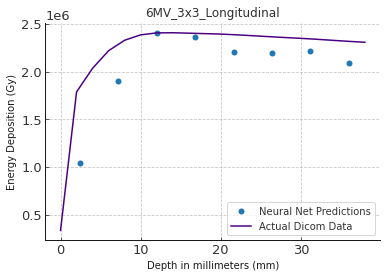

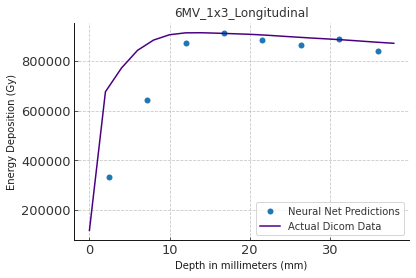

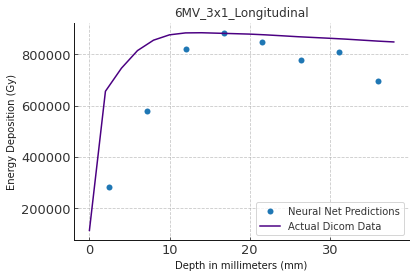

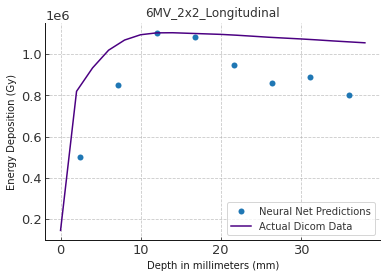

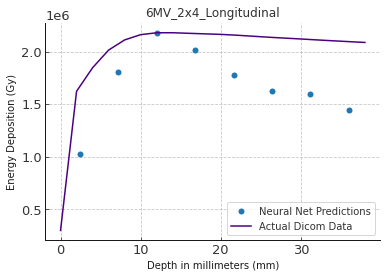

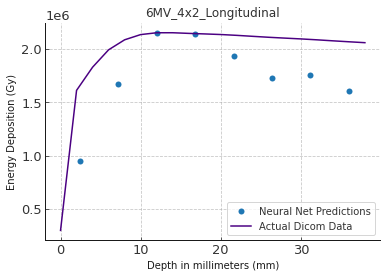

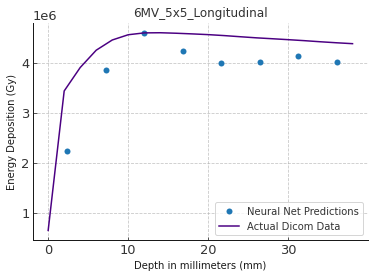

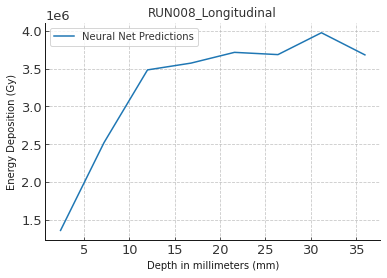

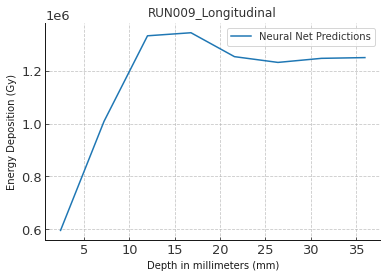

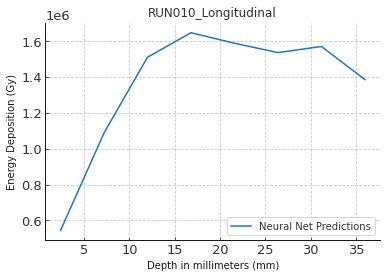

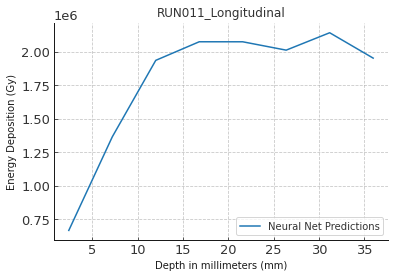

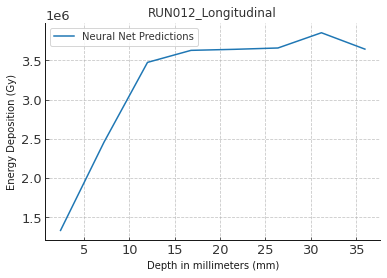

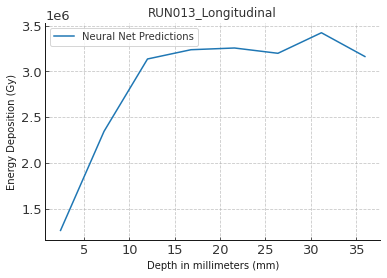

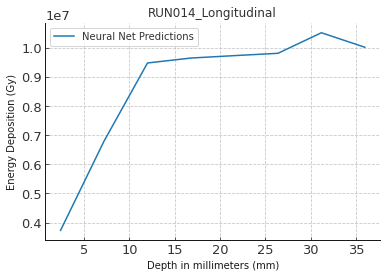

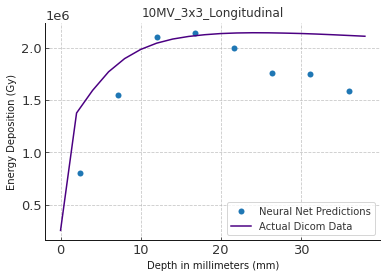

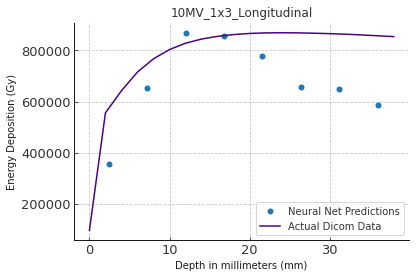

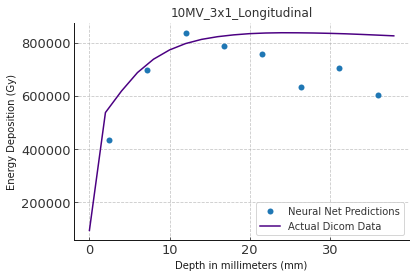

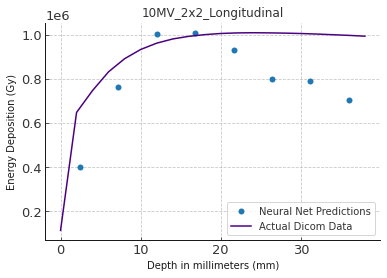

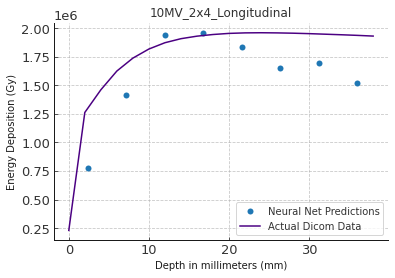

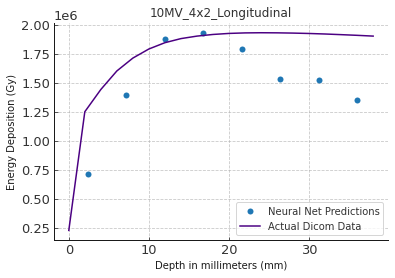

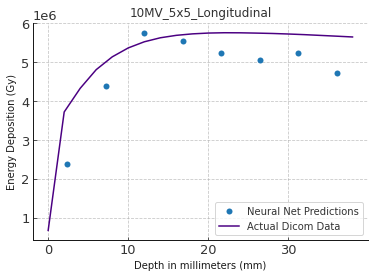

In [78]:
plt.style.use('plotting_style_sheet.txt')
counter = 0
while counter <= 20:
    counter = counter + 1

    files = sorted(glob('./../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-950/fullOhioOutputs/*'))
    if counter < 8:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))    
        df = pd.read_csv(files2[counter-1])
    elif counter < 15:
        df = np.loadtxt(files[counter-1])
    else:
        files2 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/longitude/*.csv'))
        df = pd.read_csv(files2[counter-15])
        
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    data = data.tolist()
    
    xaxis = np.arange(1, 9, 1)*4.8-2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (Gy)')
    if counter<8 or counter>14:
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        for i in range(len(data)):
            data[i] = data[i]/ratio
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions',ls='', marker = 'o')
        plt.plot(df['Distance_(mm)'].values.tolist()[0:20], (df['Gray_Value']).values.tolist()[0:20], color="indigo", label='Actual Dicom Data')
    else:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions')
    plt.legend()
    name = os.path.basename(files[counter-1]).rstrip('.txt')
    if counter < 8:
        info = (os.path.basename(files2[counter-1]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Longitudinal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_long.pdf')
    elif counter < 15:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))
        info = (os.path.basename(files2[counter-8]).rstrip('.csv')).split('_')
        plt.title('RUN' + name.lstrip('OhioOutput') + '_Longitudinal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + '2.5MV' + '_' + info[2] + '_long.pdf')
    else:
        info = (os.path.basename(files2[counter-15]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Longitudinal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_long.pdf')

/home/jupyter-owen/.conda/envs/dosimeter/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


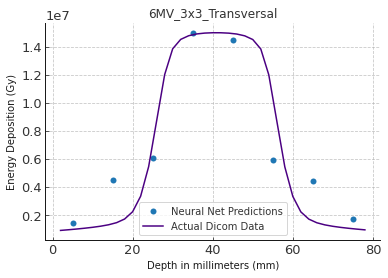

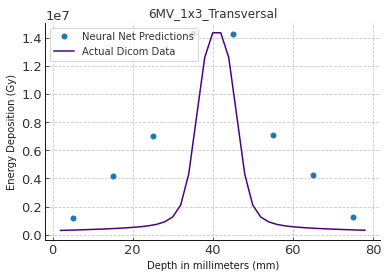

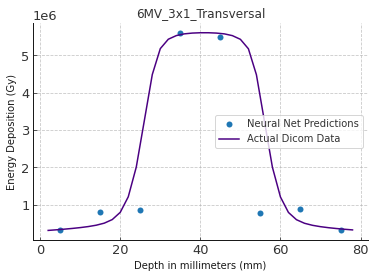

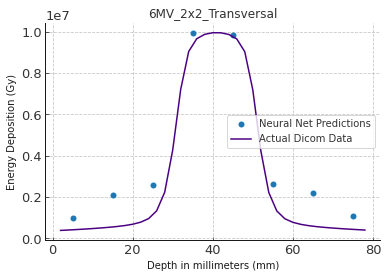

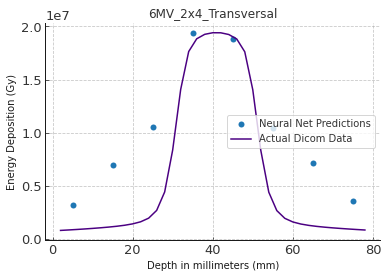

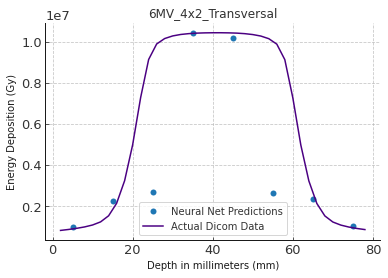

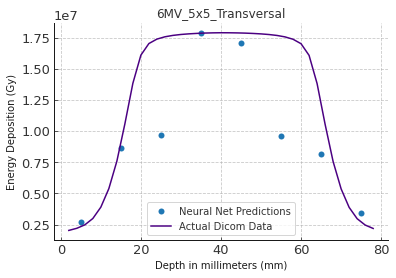

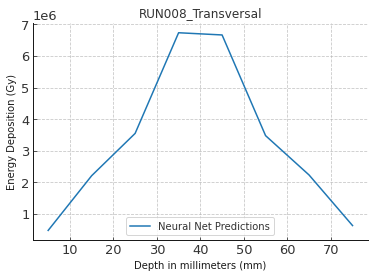

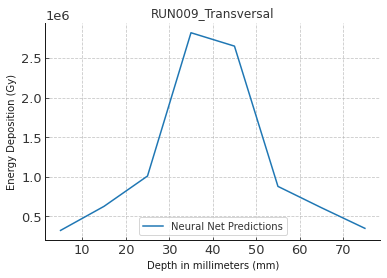

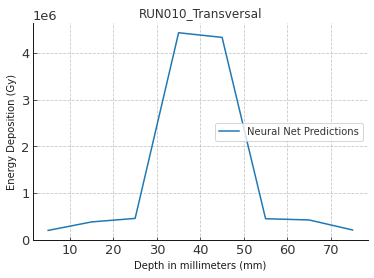

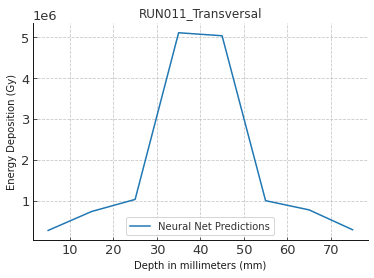

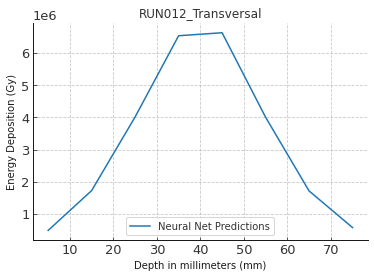

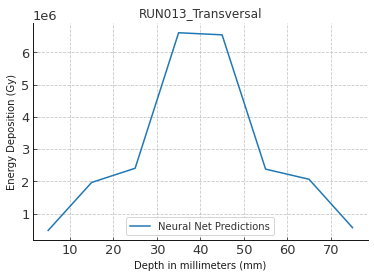

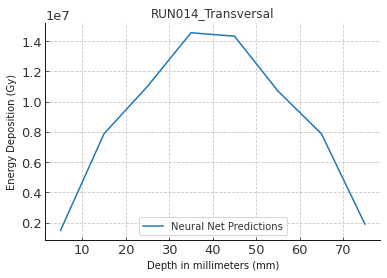

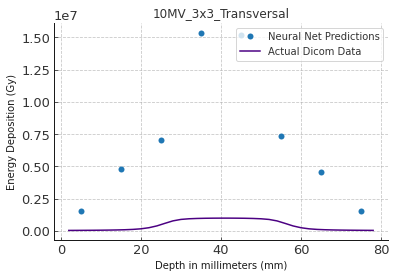

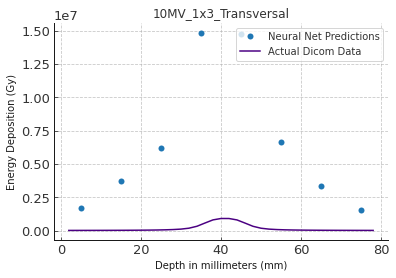

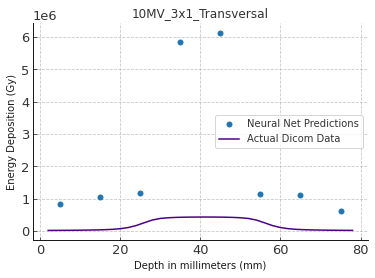

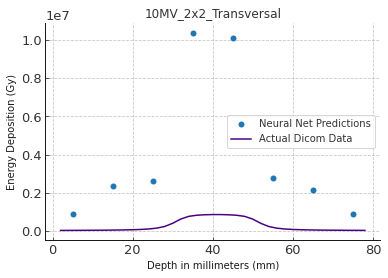

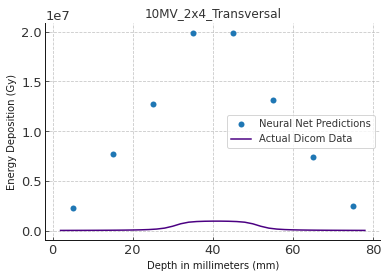

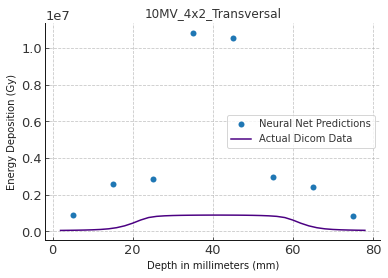

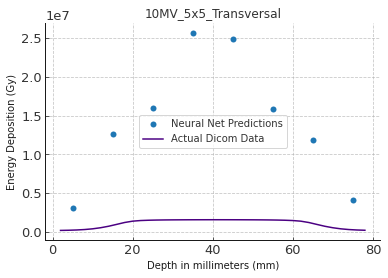

In [79]:
plt.style.use('plotting_style_sheet.txt')
counter = 0
while counter <= 20:
    counter = counter + 1
    xaxis = np.arange(1, 9, 1)*10-5
            
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(1).sum(1)
    data = data.tolist()

    files = sorted(glob('./../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-950/fullOhioOutputs/*'))
    if counter < 8:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/lattitude/*.csv'))    
        df = pd.read_csv(files2[counter-1])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        for i in range(len(data)):
            data[i] = data[i]/ratio
        dicomX = (df['Distance_(mm)'].values.tolist())[81:-81]
        dicomY = (df['Gray_Value'].values.tolist())[81:-81]
        for i in range(len(dicomX)):
            dicomX[i] = dicomX[i] - 160
    elif counter < 15:
        df = np.loadtxt(files[counter-1])
    else:
        files2 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/lattitude/*.csv'))
        df = pd.read_csv(files2[counter-15])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        for i in range(len(data)):
            data[i] = data[i]/ratio
        dicomX = (df['Distance_(mm)'].values.tolist())[81:-81]
        dicomY = (df['Gray_Value'].values.tolist())[81:-81]
        for i in range(len(dicomX)):
            dicomX[i] = dicomX[i] - 160
        for i in range(len(dicomY)):
            dicomY[i] = dicomY[i] * ratio
    
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (Gy)')
    if counter<8 or counter>14:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions',ls='', marker = 'o')
        plt.plot(dicomX, dicomY, color="indigo", label='Actual Dicom Data')
    else:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions')
    plt.legend()
    name = os.path.basename(files[counter-1]).rstrip('.txt')
    if counter < 8:
        info = (os.path.basename(files2[counter-1]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Transversal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_latt.pdf')
    elif counter < 15:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/lattitude/*.csv'))
        info = (os.path.basename(files2[counter-8]).rstrip('.csv')).split('_')
        plt.title('RUN' + name.lstrip('OhioOutput') + '_Transversal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + '2.5MV' + '_' + info[2] + '_latt.pdf')
    else:
        info = (os.path.basename(files2[counter-15]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Transversal')
        fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_latt.pdf')

/home/jupyter-owen/.conda/envs/dosimeter/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


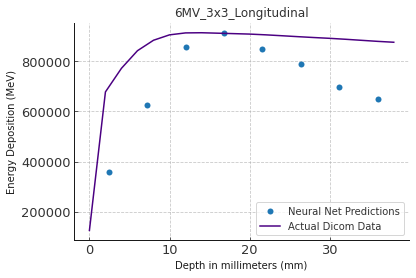

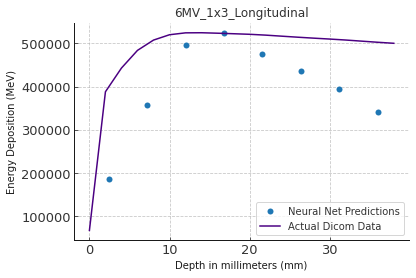

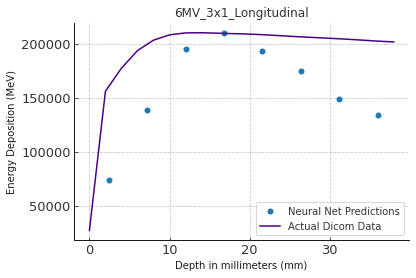

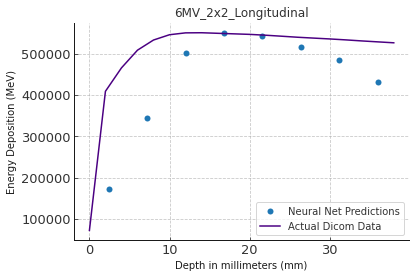

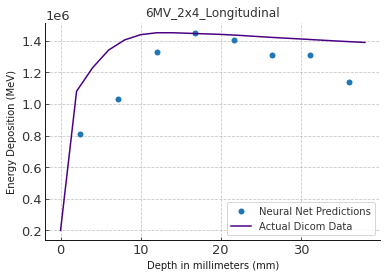

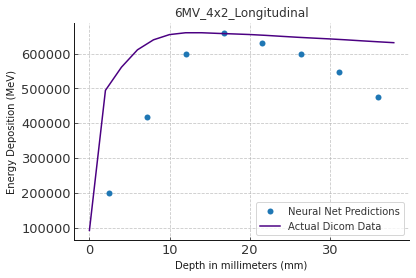

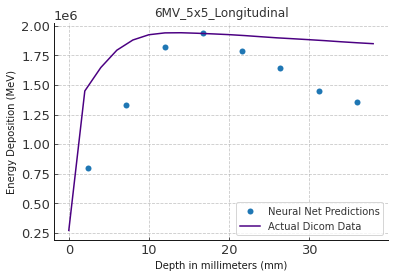

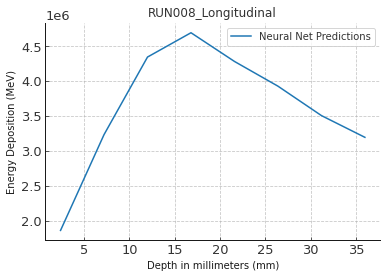

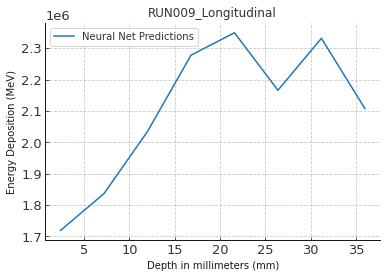

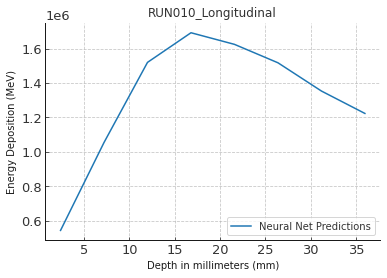

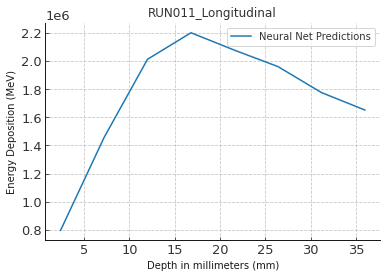

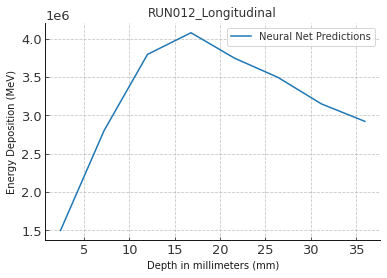

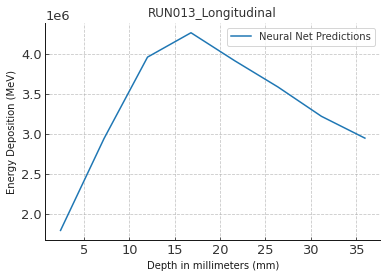

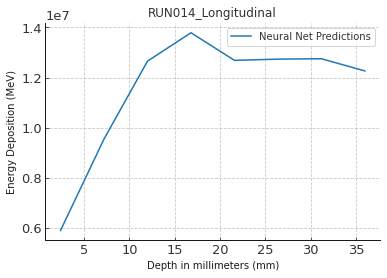

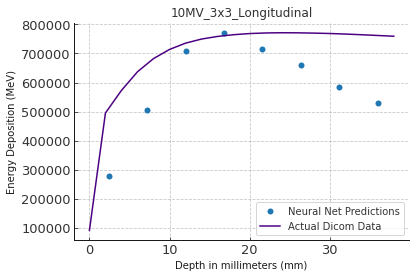

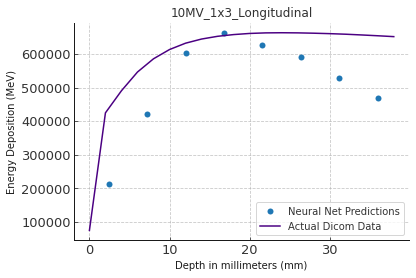

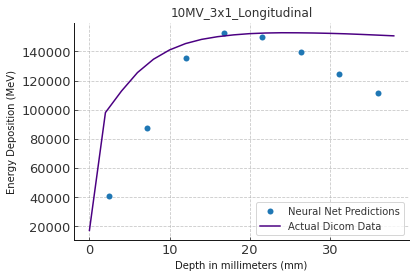

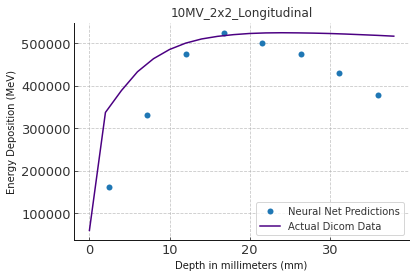

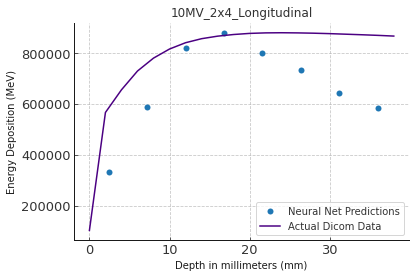

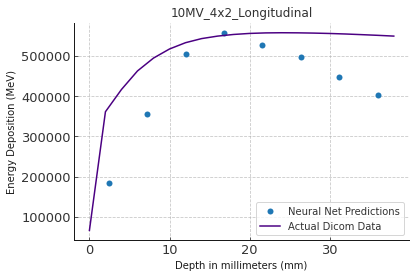

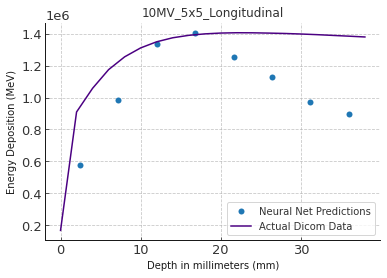

In [63]:
plt.style.use('plotting_style_sheet.txt')
counter = 0
while counter <= 20:
    counter = counter + 1

    files = sorted(glob('./../neural_nets/JuliaOutputs/OptimizedRuns/Run003R2-936/fullOhioOutputs/*'))
    if counter < 8:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))    
        df = pd.read_csv(files2[counter-1])
    elif counter < 15:
        df = np.loadtxt(files[counter-1])
    else:
        files2 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/longitude/*.csv'))
        df = pd.read_csv(files2[counter-15])
        
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    
    xaxis = np.arange(1, 9, 1)*4.8-2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    if counter<8 or counter>14:
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions',ls='', marker = 'o')
        plt.plot(df['Distance_(mm)'].values.tolist()[0:20], (df['Gray_Value']*ratio).values.tolist()[0:20], color="indigo", label='Actual Dicom Data')
    else:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions')
    plt.legend()
    name = os.path.basename(files[counter-1]).rstrip('.txt')
    if counter < 8:
        info = (os.path.basename(files2[counter-1]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Longitudinal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_long.pdf')
    elif counter < 15:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))
        info = (os.path.basename(files2[counter-8]).rstrip('.csv')).split('_')
        plt.title('RUN' + name.lstrip('OhioOutput') + '_Longitudinal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + '2.5MV' + '_' + info[2] + '_long.pdf')
    else:
        info = (os.path.basename(files2[counter-15]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Longitudinal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_long.pdf')

/home/jupyter-owen/.conda/envs/dosimeter/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


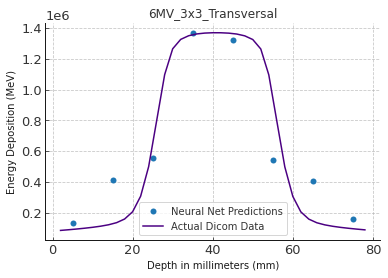

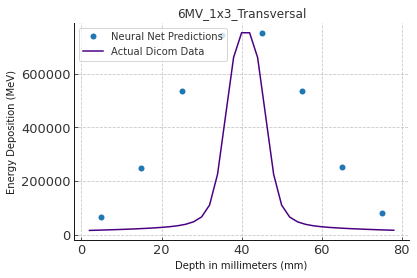

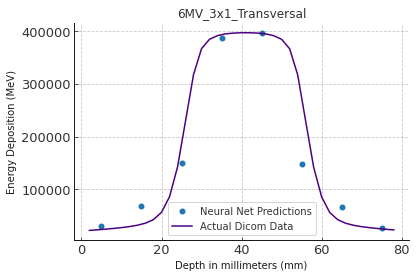

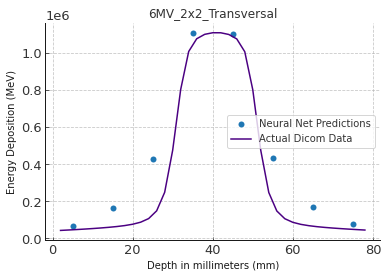

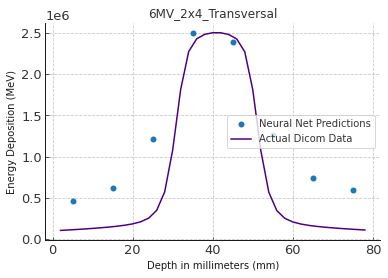

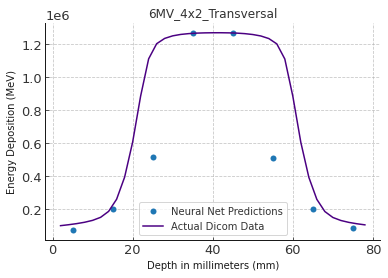

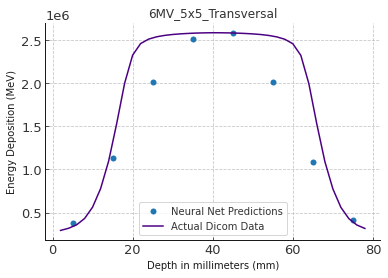

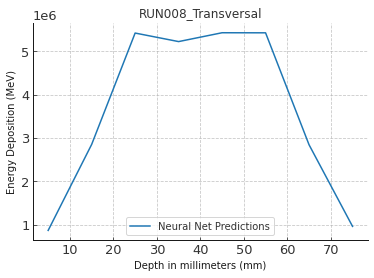

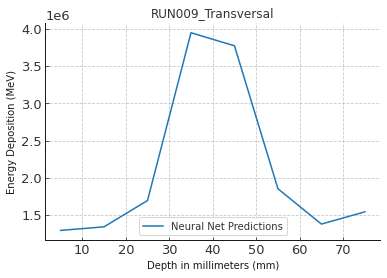

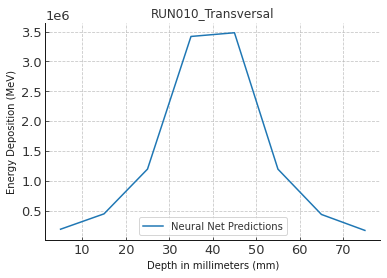

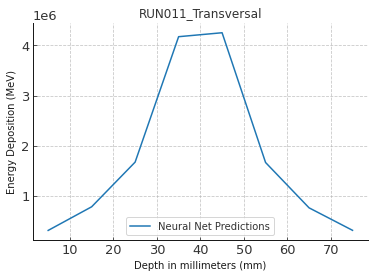

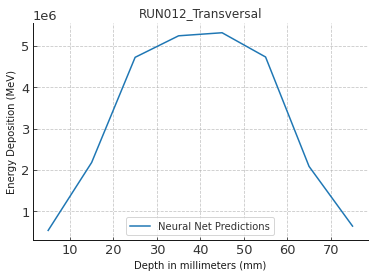

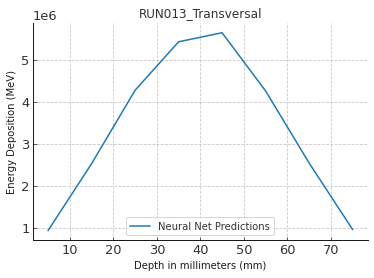

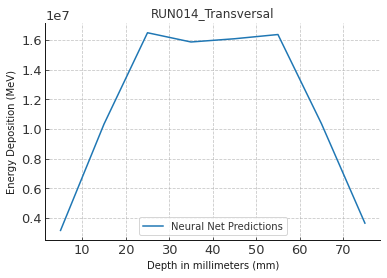

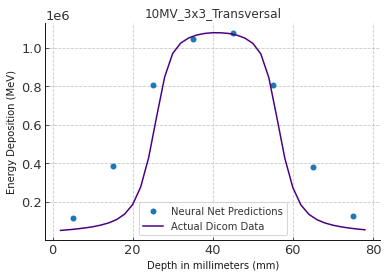

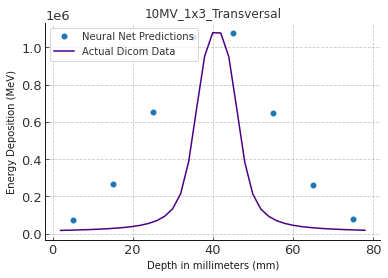

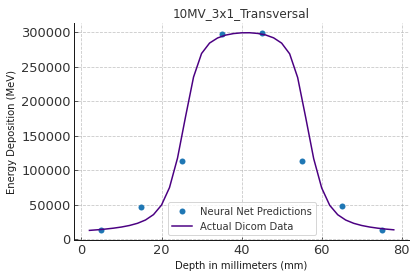

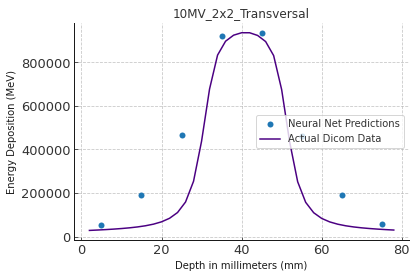

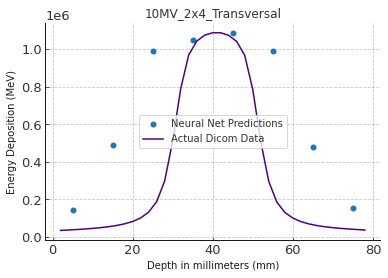

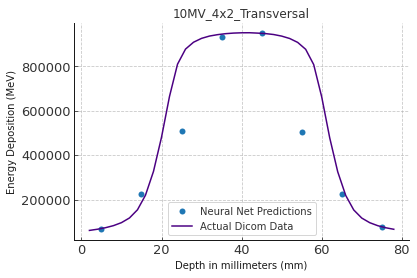

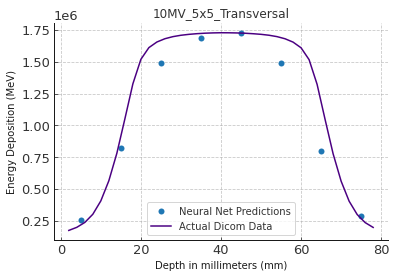

In [61]:
plt.style.use('plotting_style_sheet.txt')
counter = 0
while counter <= 20:
    counter = counter + 1
    xaxis = np.arange(1, 9, 1)*10-5
            
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(1).sum(1)

    files = sorted(glob('./../neural_nets/JuliaOutputs/OptimizedRuns/Run003R2-936/fullOhioOutputs/*'))
    if counter < 8:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/lattitude/*.csv'))    
        df = pd.read_csv(files2[counter-1])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        dicomX = (df['Distance_(mm)'].values.tolist())[81:-81]
        dicomY = (df['Gray_Value'].values.tolist())[81:-81]
        for i in range(len(dicomX)):
            dicomX[i] = dicomX[i] - 160
        for i in range(len(dicomY)):
            dicomY[i] = dicomY[i] * ratio
    elif counter < 15:
        df = np.loadtxt(files[counter-1])
    else:
        files2 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/lattitude/*.csv'))
        df = pd.read_csv(files2[counter-15])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        dicomX = (df['Distance_(mm)'].values.tolist())[81:-81]
        dicomY = (df['Gray_Value'].values.tolist())[81:-81]
        for i in range(len(dicomX)):
            dicomX[i] = dicomX[i] - 160
        for i in range(len(dicomY)):
            dicomY[i] = dicomY[i] * ratio
    
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    if counter<8 or counter>14:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions',ls='', marker = 'o')
        plt.plot(dicomX, dicomY, color="indigo", label='Actual Dicom Data')
    else:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions')
    plt.legend()
    name = os.path.basename(files[counter-1]).rstrip('.txt')
    if counter < 8:
        info = (os.path.basename(files2[counter-1]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Transversal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_latt.pdf')
    elif counter < 15:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/lattitude/*.csv'))
        info = (os.path.basename(files2[counter-8]).rstrip('.csv')).split('_')
        plt.title('RUN' + name.lstrip('OhioOutput') + '_Transversal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + '2.5MV' + '_' + info[2] + '_latt.pdf')
    else:
        info = (os.path.basename(files2[counter-15]).rstrip('.csv')).split('_')
        plt.title(info[1] + '_' + info[2] + '_Transversal')
        #fig.savefig('./../figures/nn2DicomComp/OSUNathanOpt001/' + info[1] + '_' + info[2] + '_latt.pdf')

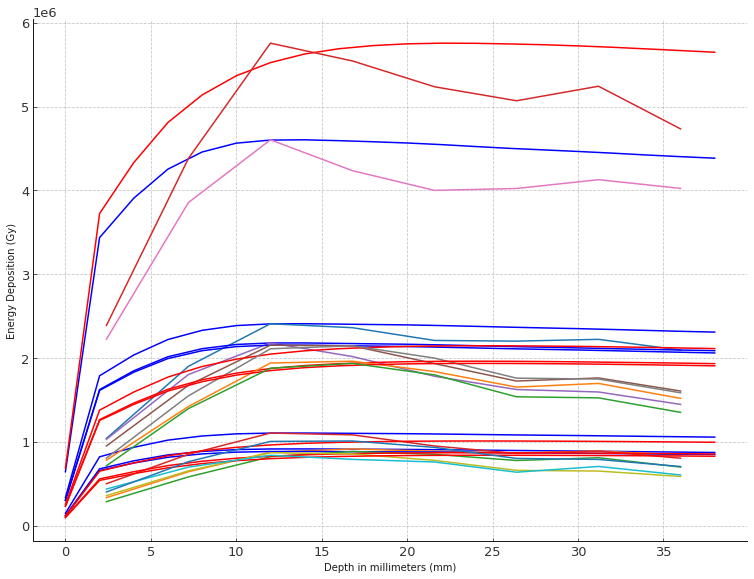

In [53]:
plt.style.use('plotting_style_sheet.txt')
fig = plt.figure(figsize=(6.4*2, 4.8*2))
counter = 0
while counter <= 20:
    counter = counter + 1

    files = sorted(glob('./../neural_nets/JuliaOutputs/OptimizedRuns/Run001R2-950/fullOhioOutputs/*'))
    files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))    
    files3 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/longitude/*.csv'))
        
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    
    xaxis = np.arange(1, 9, 1)*4.8-2.4
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (Gy)')
    if counter < 8:
        df = pd.read_csv(files2[counter-1])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        plt.plot(df['Distance_(mm)'].values.tolist()[0:20], (df['Gray_Value']).values.tolist()[0:20], label='Actual Dicom Data', color = 'blue')
        plt.plot(xaxis, np.flip(data, 0)/ratio, label='Neural Net Predictions')
    elif counter >= 15:
        df = pd.read_csv(files3[counter-15])
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        plt.plot(df['Distance_(mm)'].values.tolist()[0:20], (df['Gray_Value']).values.tolist()[0:20], label='Actual Dicom Data', color = 'red')
        plt.plot(xaxis, np.flip(data, 0)/ratio, label='Neural Net Predictions')

/home/jupyter-owen/.conda/envs/dosimeter/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


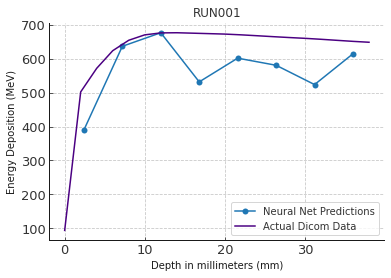

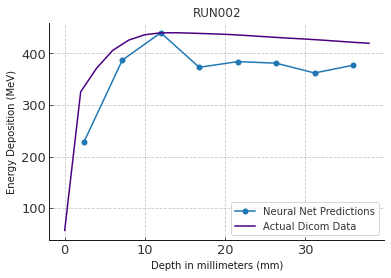

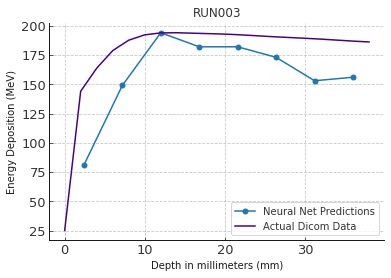

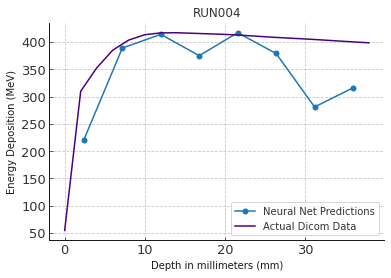

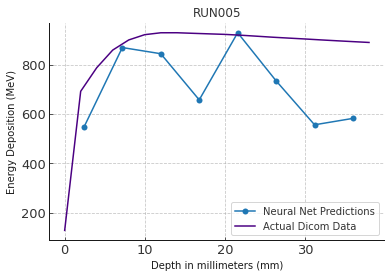

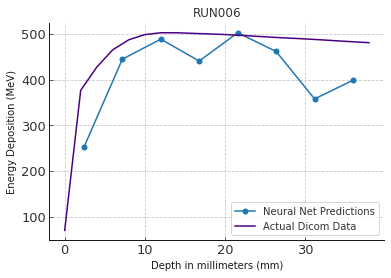

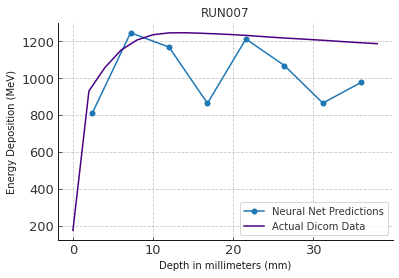

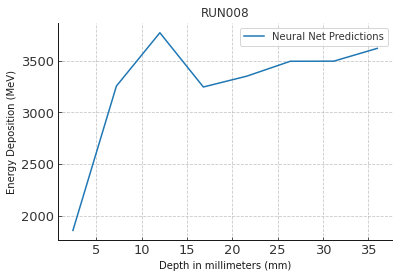

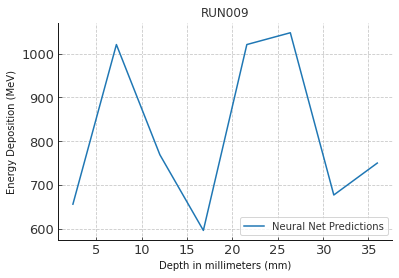

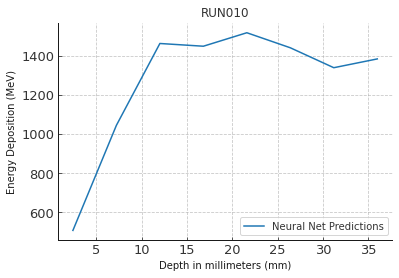

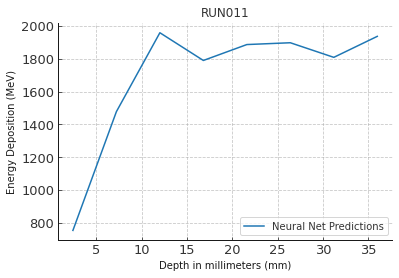

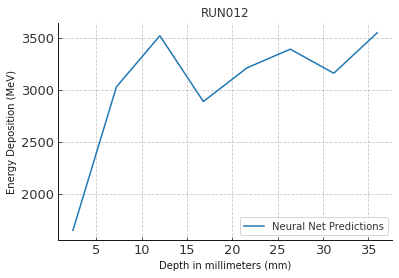

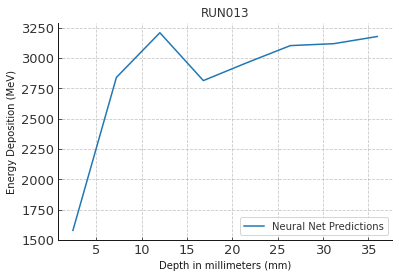

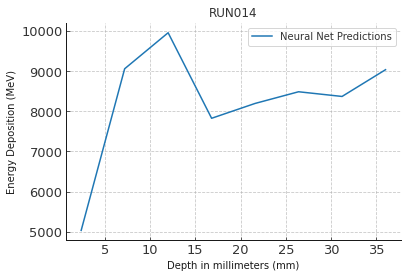

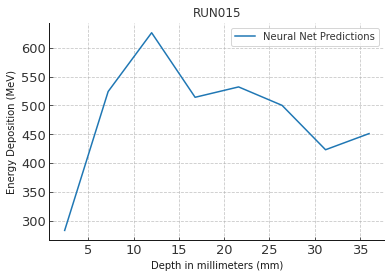

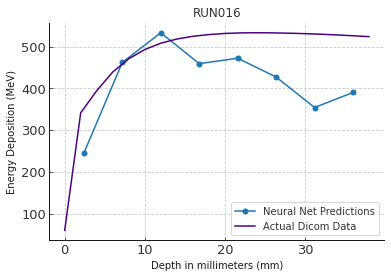

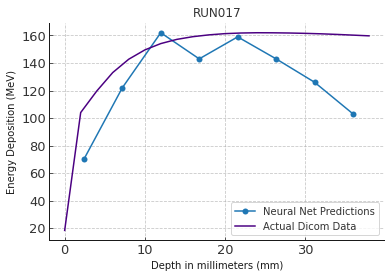

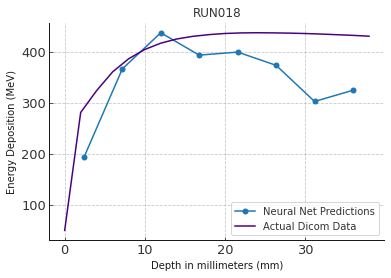

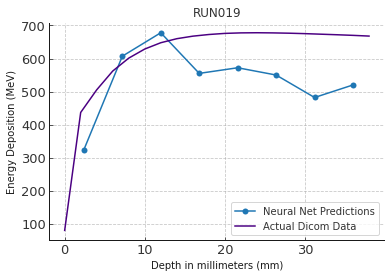

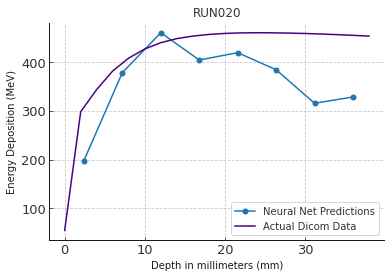

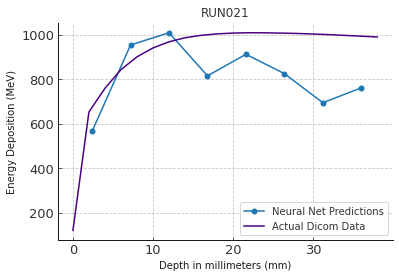

In [64]:
plt.style.use('plotting_style_sheet.txt')
counter = 0
while counter <= 20:
    counter = counter + 1

    files = sorted(glob('./../neural_nets/JuliaOutputs/RubinRuns/Run000R2-944/fullOhioOutputs/*'))
    if counter<8:
        files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))    
        df = pd.read_csv(files2[counter-1])
    elif counter <15:
        df = np.loadtxt(files[counter-1])
    else:
        files2 = sorted(glob('./../supplimentary_material/dicoms/10MV_results/longitude/*.csv'))
        df = pd.read_csv(files2[counter-15])
        
    data = np.loadtxt(files[counter-1])
    data = data.reshape((8,8,8))
    data = data.sum(0).sum(1)
    
    xaxis = np.arange(1, 9, 1)*4.8-2.4
    fig = plt.figure()
    plt.xlabel('Depth in millimeters (mm)')
    plt.ylabel('Energy Deposition (MeV)')
    if counter<8 or counter>15:
        ratio = max(data)/max(df['Gray_Value'].values.tolist())
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions', marker = 'o')
        plt.plot(df['Distance_(mm)'].values.tolist()[0:20], (df['Gray_Value']*ratio).values.tolist()[0:20], color="indigo", label='Actual Dicom Data')
    else:
        plt.plot(xaxis, np.flip(data, 0), label='Neural Net Predictions')
    plt.legend()
    name = os.path.basename(files[counter-1]).rstrip('.txt')
    plt.title('RUN' + name.lstrip('OhioOutput'))

In [65]:
files2 = sorted(glob('./../supplimentary_material/dicoms/6MV_results/longitude/*.csv'))
files2[5]

'./../supplimentary_material/dicoms/6MV_results/longitude/6_6MV_4x2_long.csv'

In [7]:
np.ones((3,4,5)).sum(2).sum(1)

array([20., 20., 20.])